## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
### 1) compute the camera calibration using chessboard images
First, load images and detect corners.

In [7]:
import cv2
import glob
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
import numpy as np
import pickle
import random
%matplotlib inline

In [8]:
def loadChessboardImages(images):
        objp = np.zeros((6*9,3), np.float32)
        objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

        # Arrays to store object points and image points from all the images.
        objpoints = [] # 3d points in real world space
        imgpoints = [] # 2d points in image plane.
        marked_imgs = [] # marked images
        original_imgs = [] # original images

        # Step through the list and search for chessboard corners
        img_amount = 0
        for fname in images:
                img = cv2.imread(fname)
                imgc = img.copy()
                gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

                # Find the chessboard corners
                ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

                # If found, add object points, image points
                if ret == True:
                        objpoints.append(objp)
                        imgpoints.append(corners)
                        original_imgs.append(imgc)
                        drawimg = cv2.drawChessboardCorners(img, (9,6), corners, ret)
                        marked_imgs.append(drawimg)
                img_amount += 1

#         print('total {} image(s) loaded.'.format(img_amount))
#         lens = len(original_imgs)
#         print('total {} image(s) found corners.'.format(lens))
        
        return objpoints, imgpoints, marked_imgs, original_imgs

def showMarked(images, index):
    # make a list of calibration images
    # images = glob.glob('camera_cal/calibration*.jpg')
    objpoints, imgpoints, marked_imgs, original_imgs = loadChessboardImages(images)

    # Pick up an image to show the result
    original_img = original_imgs[index]
    marked_img = marked_imgs[index]

    # plt.rcParams["figure.figsize"] = (30,20)
    # plt.imshow(original_img)
    fig1, axes1 = plt.subplots(nrows=2, figsize=(10,10))
    axes1[0].imshow(original_img)
    axes1[0].set_title('original image')
    axes1[1].imshow(marked_img)
    axes1[1].set_title('corners marked')
    
    return original_imgs, marked_img

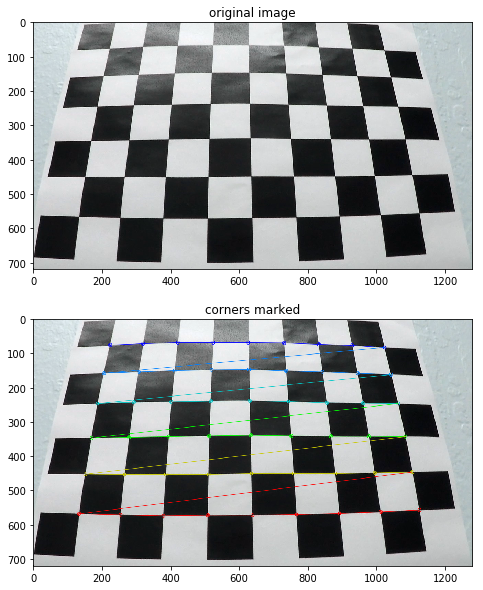

In [10]:
# test run images
# use index 12 as an example to illustrate result
images = glob.glob('camera_cal/calibration*.jpg')
original_imgs, marked_img = showMarked(images, index=12)

Second, calibrate the camera, undistort image, and show the result.

In [11]:
def cameraCalibration(images):
    # load all chessboard images first
    objpoints, imgpoints, marked_imgs, original_imgs = loadChessboardImages(images)
    # cailbrate camera
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, original_imgs[0].shape[0:2], None, None)
    
    return ret, mtx, dist, rvecs, tvecs

Text(0.5,1,'undistorted chessboard image')

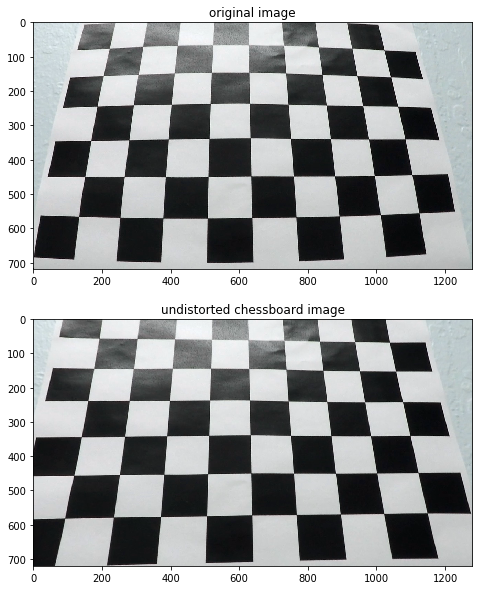

In [13]:
# sample test run
# use result above to undistort
# test run, with each index
images = glob.glob('camera_cal/calibration*.jpg')
ret, mtx, dist, rvecs, tvecs = cameraCalibration(images)
dst_img = cv2.undistort(original_imgs[12], mtx, dist, None, mtx)

# show results
fig2, axes2 = plt.subplots(nrows=2, figsize=(10,10))
axes2[0].imshow(original_imgs[12])
axes2[0].set_title('original image')
axes2[1].imshow(dst_img)
axes2[1].set_title('undistorted chessboard image')

### 2) apply distortion correction to images

In [14]:
# distortion correction
def distCorrection(image, mtx, dist):
    # un-distortion
    dst_image = cv2.undistort(image, mtx, dist, None, mtx)
    
    return dst_image

Done correction.


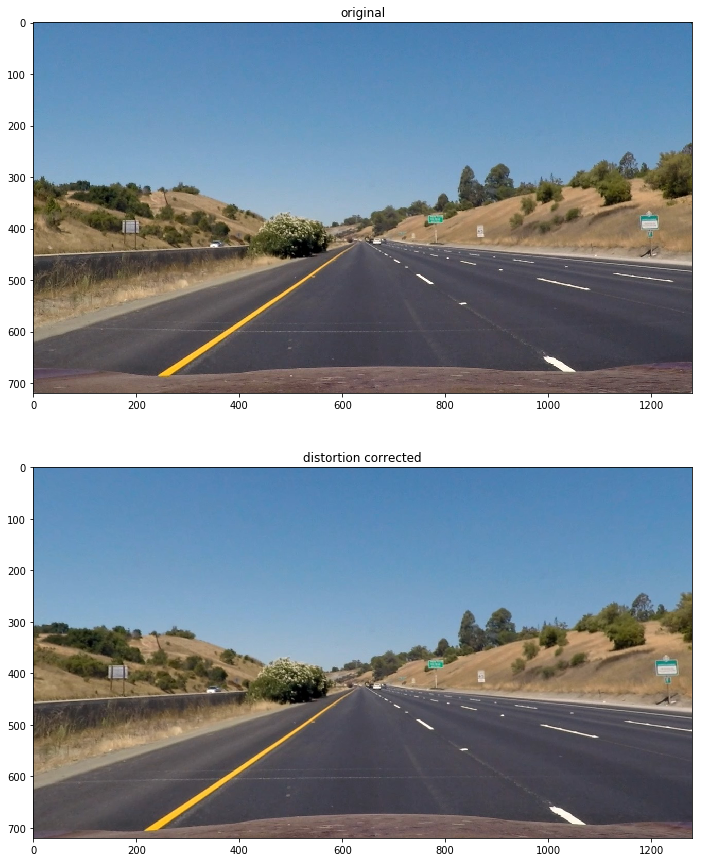

In [96]:
# sample test run
testimages = glob.glob('test_images/*.jpg')
# change index to pick different images
index = 0
testimage = cv2.imread(testimages[index])
image_copy = testimage.copy()

# correct distortion
corrected_image = distCorrection(testimage, mtx, dist)

# convert to RGB to show images
testimage = cv2.cvtColor(testimage, cv2.COLOR_BGR2RGB)
corrected_image = cv2.cvtColor(corrected_image, cv2.COLOR_BGR2RGB)

fig3, axes3 = plt.subplots(nrows=2, figsize=(15,15))
axes3[0].imshow(testimage) # original test image
axes3[0].set_title('original')
axes3[1].imshow(corrected_image) # test image after distortion corrected
axes3[1].set_title('distortion corrected')
print('Done correction.')

### 3) use color transforms, gradients, etc., to create a thresholded binary image.

In [97]:
# hls color threshold (use s channel by default), and return binary image
def hlsSelect(img, thresh=(0, 255), color_channel='s'):
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    channel = hls[:,:,2]
    
    # other 2 choices
    if color_channel == 'h':
        channel = hls[:,:,0]
    elif color_channel == 'l':
        channel = hls[:,:,1]
        
    binary_output = np.zeros_like(channel)
    binary_output[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    return binary_output

# calculate Sobel gradient, and return binary image
def absSobelThresh(img, orient='x', sobel_kernel=3, color_space='gray', thresh_min=0, thresh_max=255):
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if color_space == 'gray':
        image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    else:
        hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        
        if color_space == 'h':
            image = hls[:,:,0]
        elif color_space == 'l':
            image = hls[:,:,1]
        elif color_space == 's':
            image = hls[:,:,2]
        else:
            print('Wrong color space in argument: color_space, using gray by default...')
            image = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    else:
        abs_sobel = np.absolute(cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    return binary_output

def dirThresh(img, sobel_kernel=3, thresh_min=0, thresh_max=np.pi/2):
    img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    
    return binary_output

# Combine the two binary thresholds
def combineBinary(bin1, bin2):
    
    combined_binary = np.zeros_like(bin1)
    combined_binary[(bin1 == 1) | (bin2 == 1)] = 1
    
    return combined_binary


Text(0.5,1,'combined binary')

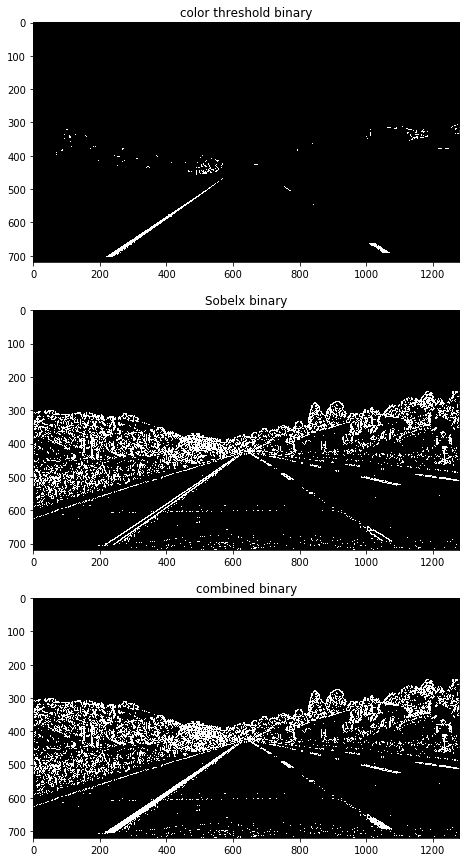

In [98]:
# sample test run
# show results, and pick up better combination
# calculate s_channel color binary result
color_s_binary = hlsSelect(corrected_image, thresh=(170,255), color_channel='s')

# calculate Sobel_x binary
sx_binary = absSobelThresh(corrected_image, orient='x', sobel_kernel=3, color_space='gray', thresh_min=10, thresh_max=160)
dir_binary = dirThresh(corrected_image, sobel_kernel=3, thresh_min=0.79, thresh_max=1.2)

# calculate combination
combined_bin = combineBinary(sx_binary, color_s_binary)

# show results
fig4, axes4 = plt.subplots(nrows=3, figsize=(15,15))
axes4[0].imshow(color_s_binary, cmap='gray')
axes4[0].set_title('color threshold binary')
axes4[1].imshow(sx_binary, cmap='gray')
axes4[1].set_title('Sobelx binary')
axes4[2].imshow(combined_bin, cmap='gray')
axes4[2].set_title('combined binary')


### 4) apply a perspective transform to rectify binary image ("birds-eye view")

In [99]:
def birdsEye(binary_image, src, dst):
    # use straight line first to test, and then use curved line to see radius
    img_size = (binary_image.shape[1], binary_image.shape[0])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    binary_warped = cv2.warpPerspective(binary_image, M, img_size)
    
    return binary_warped, M, Minv

[[ -6.88126446e-01  -1.52968389e+00   1.08040093e+03]
 [ -8.88178420e-15  -2.03546646e+00   9.46491904e+02]
 [ -1.36609474e-17  -2.39013107e-03   1.00000000e+00]]
[[  1.61904762e-01  -7.51515152e-01   5.36380952e+02]
 [ -3.99680289e-15  -4.91287879e-01   4.65000000e+02]
 [ -7.80625564e-18  -1.17424242e-03   1.00000000e+00]]


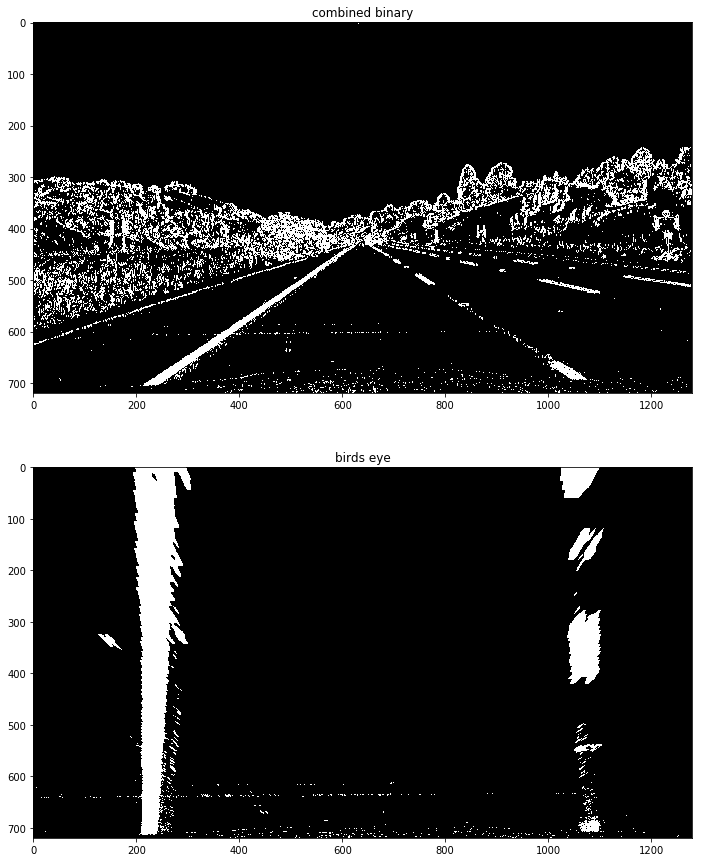

In [116]:
# sample test run, following the test image above
top_left = [595, 450]
top_right = [685, 450]
btm_right = [1080, 720]
btm_left = [200, 720]

src = np.float32([top_left, top_right, btm_right, btm_left])

# define destination points
dst = np.float32([
    [270, 0],
    [1010, 0],
    [1010, 720],
    [270, 720]])

binary_warped, M, Minv = birdsEye(combined_bin, src, dst)

fig5, axes5 = plt.subplots(nrows=2, figsize=(15,15))
axes5[0].imshow(combined_bin, cmap='gray')
axes5[0].set_title('combined binary')
axes5[1].imshow(binary_warped, cmap='gray')
axes5[1].set_title('birds eye')

# show M matrix
print(M)
print(Minv)

### 5) detect lane pixels and fit to find the lane boundary.

In [61]:
def detectLaneToBoxes(binary_warped, nwindows=9, margin=100, minpix=50, ym_per_pix=30/720, xm_per_pix=3.7/700):
    # check the histogram, which can clearly see the left and right two lanes with peaks
    #copy = binary_warped.copy()
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    #plt.plot(histogram)

    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    # nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    # margin = 100
    # Set minimum number of pixels found to recenter window
    # minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)


    return left_lane_inds, right_lane_inds, left_fit, right_fit, left_fit_m, right_fit_m, out_img, nonzerox, nonzeroy

(720, 0)

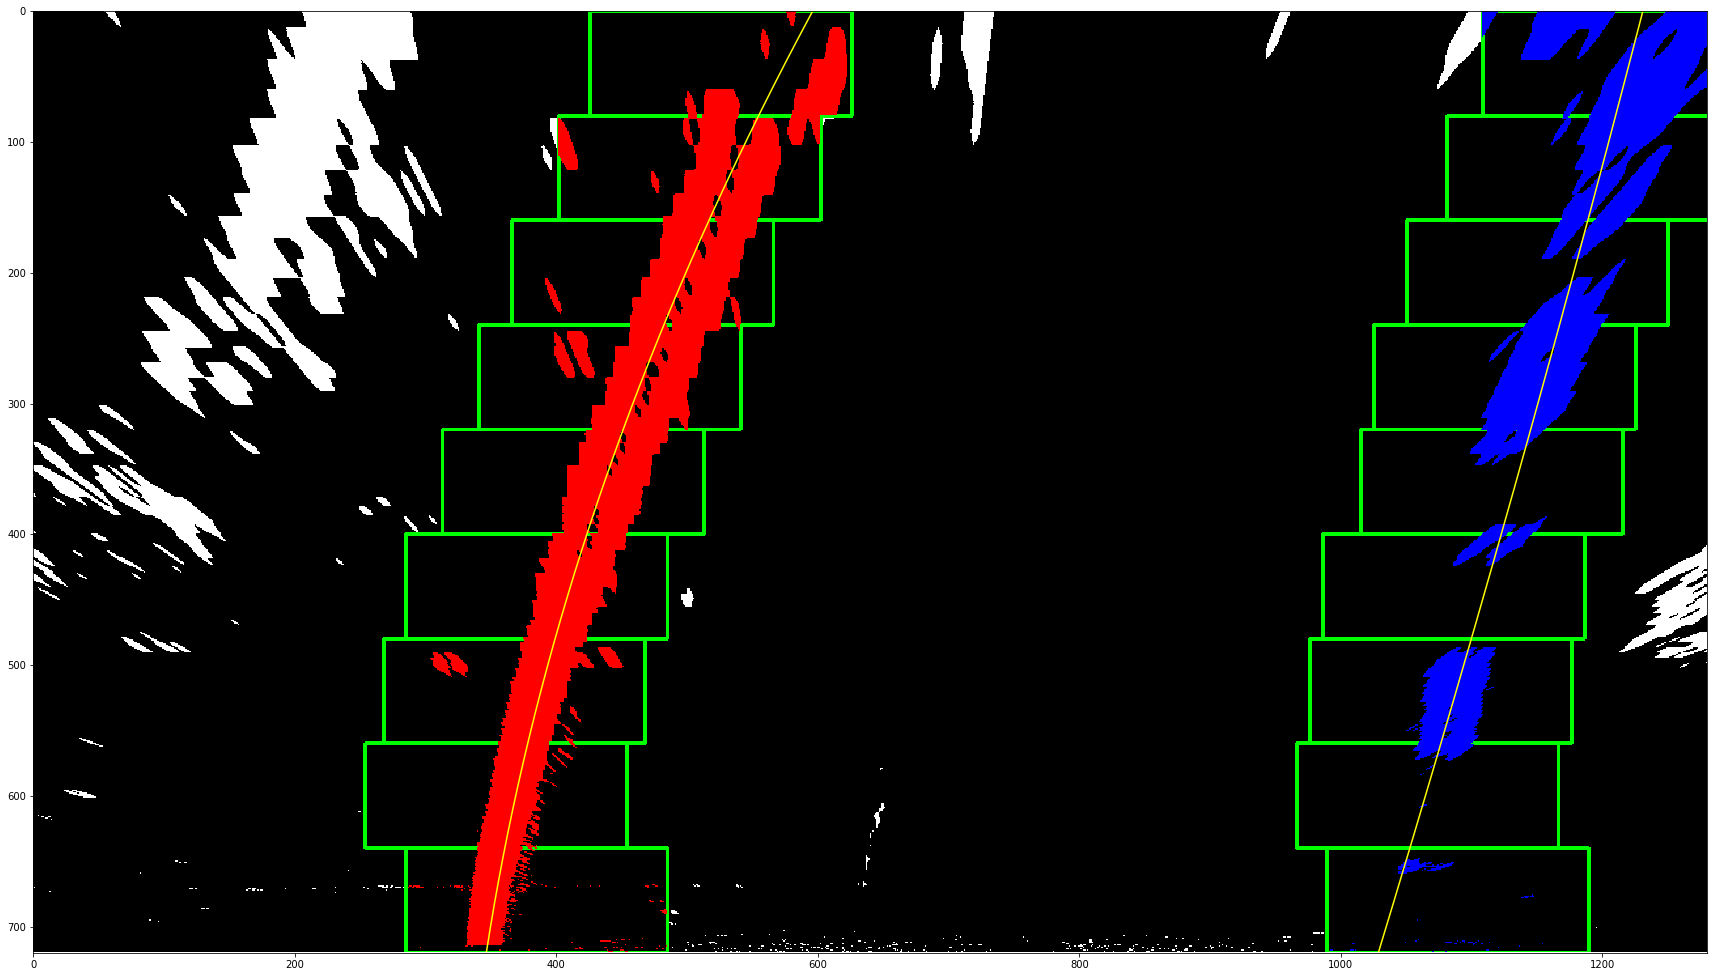

In [62]:
# sample test run
left_lane_inds, right_lane_inds, left_fit, right_fit, left_fit_m, right_fit_m, out_img, nonzerox, nonzeroy = detectLaneToBoxes(binary_warped, nwindows=9, margin=100, minpix=50)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

fig6 = plt.figure(figsize = (30,20)) 
axes6 = fig6.add_subplot(111)
axes6.imshow(out_img)

plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [63]:
def fitLanes(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds, margin=100):
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    return left_fit, right_fit, leftx, lefty, rightx, righty

(720, 0)

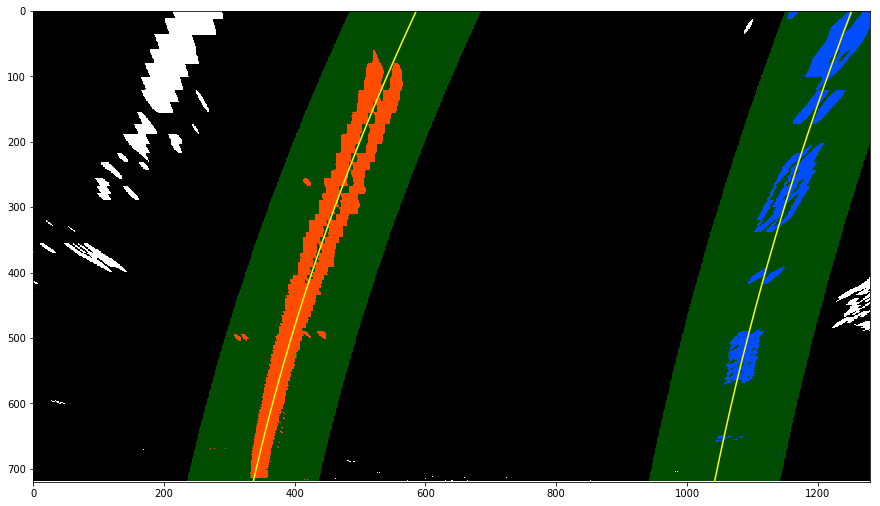

In [24]:
# sample test run 
margin = 100
left_fit, right_fit, leftx, lefty, rightx, righty = fitLanes(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds, margin)

# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)

fig7 = plt.figure(figsize = (15,15)) 
axes7 = fig7.add_subplot(111)
axes7.imshow(result)

plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

### 6) determine the curvature of the lane and vehicle position with respect to center.

In [64]:
def curvature(xm_per_pix, ym_per_pix, y_eval, leftx, lefty, rightx, righty):
    left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    
    return left_curverad, right_curverad

In [65]:
# sample test run, to show left & right curve radius

ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
y_eval = 719

left_curverad, right_curverad = curvature(xm_per_pix, ym_per_pix, y_eval, leftx, lefty, rightx, righty)

#Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')


994.449133845 m 1344.68941895 m


### 7) warp the detected lane boundaries back onto the original image.

In [66]:
def laneBoundaries(binary_warped, left_fitx, right_fitx, ploty, Minv, image_copy, corrected_image):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image_copy.shape[1], image_copy.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(corrected_image, 1, newwarp, 0.3, 0)
    
    return result

def display(image, left_curverad, right_curverad, y_eval, left_fit_m, right_fit_m, ym_per_pix, xm_per_pix, fontScale=2):
    # Calculate vehicle center
    x_max = image.shape[1] * xm_per_pix
    y_max = image.shape[0] * ym_per_pix
    car_center = x_max / 2
    
    left_lane = left_fit_m[0]*y_max**2 + left_fit_m[1]*y_max + left_fit_m[2]
    right_lane = right_fit_m[0]*y_max**2 + right_fit_m[1]*y_max + right_fit_m[2]
    mid_lane = left_lane + (right_lane-left_lane)/2
    bias = mid_lane - car_center
    
    if bias > 0:
        message = '{:.2f} m right'.format(bias)
    else:
        message = '{:.2f} m left'.format(-bias)

    # display on image
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontColor = (255, 255, 255)
    cv2.putText(image, 'Left curvature: {:.0f} m'.format(left_curverad), (10, 50), font, fontScale, fontColor, 2)
    cv2.putText(image, 'Right curvature: {:.0f} m'.format(right_curverad), (10, 120), font, fontScale, fontColor, 2)
    cv2.putText(image, 'Vehicle is {} of center'.format(message), (10, 190), font, fontScale, fontColor, 2)

    return (image)

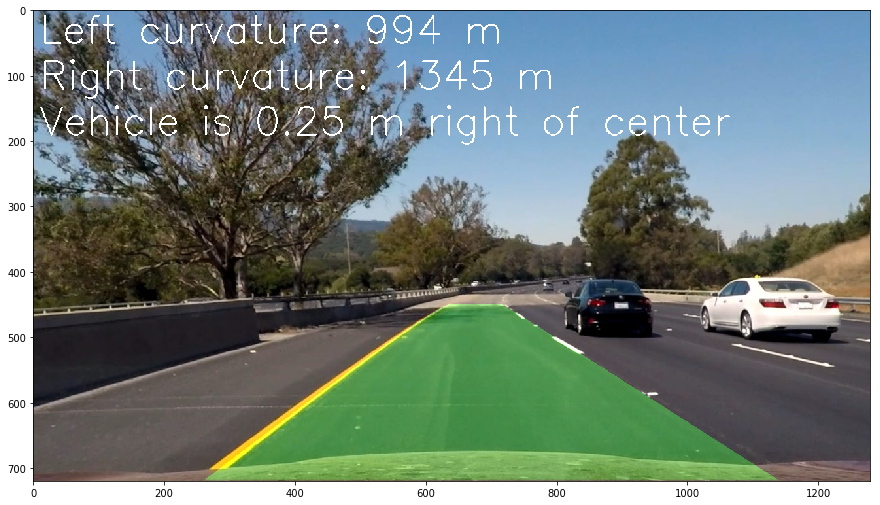

In [67]:
result = laneBoundaries(binary_warped, left_fitx, right_fitx, ploty, Minv, image_copy, corrected_image)
result = display(result, left_curverad, right_curverad, y_eval, left_fit_m, right_fit_m, ym_per_pix, xm_per_pix)

fig8 = plt.figure(figsize = (15,15)) 
axes8 = fig8.add_subplot(111)
axes8.imshow(result)

### 7+) wrap to a single pipeline, and show final output only.

In [126]:
def cameraPreCalibration():
    images = glob.glob('camera_cal/calibration*.jpg')
    ret, mtx, dist, rvecs, tvecs = cameraCalibration(images)
    
    return ret, mtx, dist, rvecs, tvecs

def imagePipeline(testimage, ret, mtx, dist, rvecs, tvecs):
    image_copy = testimage.copy()
    corrected_image = distCorrection(testimage, mtx, dist)
    corrected_image = cv2.cvtColor(corrected_image, cv2.COLOR_BGR2RGB)

    color_s_binary = hlsSelect(corrected_image, thresh=(170,255), color_channel='s')
    sx_binary = absSobelThresh(corrected_image, orient='x', sobel_kernel=3, color_space='gray', thresh_min=20, thresh_max=100)
    #dir_binary = dirThresh(corrected_image, sobel_kernel=3, thresh_min=0.79, thresh_max=1.2)

    combined_bin = combineBinary(sx_binary, color_s_binary)

    top_left = [595, 450]
    top_right = [685, 450]
    btm_right = [1080, 720]
    btm_left = [200, 720]
    
    src = np.float32([top_left, top_right, btm_right, btm_left])
    dst = np.float32([[270, 0], [1010, 0], [1010, 720], [270, 720]])
    binary_warped, M, Minv = birdsEye(combined_bin, src, dst)
    
    left_lane_inds, right_lane_inds, left_fit, right_fit, left_fit_m, right_fit_m, out_img, nonzerox, nonzeroy = detectLaneToBoxes(binary_warped, nwindows=9, margin=100, minpix=50)
    margin = 100
    left_fit, right_fit, leftx, lefty, rightx, righty = fitLanes(binary_warped, left_fit, right_fit, left_lane_inds, right_lane_inds, margin)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    y_eval = 719

    left_curverad, right_curverad = curvature(xm_per_pix, ym_per_pix, y_eval, leftx, lefty, rightx, righty)
    result = laneBoundaries(binary_warped, left_fitx, right_fitx, ploty, Minv, image_copy, corrected_image)
    result = display(result, left_curverad, right_curverad, y_eval, left_fit_m, right_fit_m, ym_per_pix, xm_per_pix)
    
    return result

Processing...
Done!


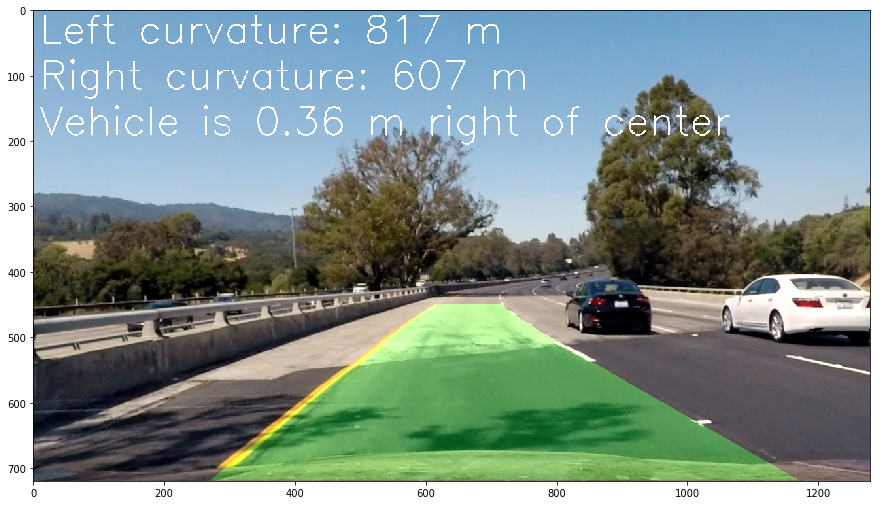

In [127]:
# main code to run pipeline for single image
# camera calibration
ret, mtx, dist, rvecs, tvecs = cameraPreCalibration()

# load test images
testimages = glob.glob('test_images/*.jpg')
# change index to pick different images
index = 5
testimage = cv2.imread(testimages[index])

# processing
print('Processing...')
result = imagePipeline(testimage, ret, mtx, dist, rvecs, tvecs)

print('Done!')
fig9 = plt.figure(figsize = (15,15)) 
axes9 = fig9.add_subplot(111)
axes9.imshow(result)

### 8) output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

In [71]:
ret, mtx, dist, rvecs, tvecs = cameraPreCalibration()

In [128]:
vidcap = cv2.VideoCapture('project_video.mp4')
success = True

fourcc = cv2.VideoWriter_fourcc(*'mp4v') # Be sure to use lower case
out = cv2.VideoWriter('out.mp4', fourcc, 20.0, (1280,720))

while success == True:
    success, image = vidcap.read()
    #print('Read a new frame: ', success)
    res = imagePipeline(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), ret, mtx, dist, rvecs, tvecs)
#    cv2.imwrite("test_results/frame%d.jpg" % count, res)
    out.write(res)
    
vidcap.release()
vout.release()

error: /Users/jenkins/miniconda/1/x64/conda-bld/conda_1486587097465/work/opencv-3.1.0/modules/imgproc/src/color.cpp:7341: error: (-215) scn == 3 || scn == 4 in function ipp_cvtColor
